# Exploratory Data Analysis: Chest X-Ray Images (Pneumonia)

In this notebook we will analyze Chest X-Ray Images (Pneumonia), made available on Kaggle. The chest ray images made available were selected from patients one to five years old, X-ray imaging performed as part of patients' routine clinical care.

### 1. Setup and Imports

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from glob import glob

base_path = '../data/raw'
train_path = os.path.join(base_path, 'train')
val_path = os.path.join(base_path, 'val')
test_path = os.path.join(base_path, 'test')

### 2. Data overview

Let's check out the number of images in each category, normal/pneumonia across the train, val and test datasets, in order to start getting a grasp for our dataset.

In [4]:
data_summary = []
for split in ['train', 'val', 'test']:
    path = os.path.join(base_path, split)
    for label in ['NORMAL', 'PNEUMONIA']:
        label_path = os.path.join(path, label)
        count = len(os.listdir(label_path))
        data_summary.append({'Split': split, 'Label': label, 'Count': count})

df_summary = pd.DataFrame(data_summary)

print('Image counts per split and label:')
print(df_summary)

total_count = df_summary['Count'].sum()
print(f'Total Count: {total_count}')

pivot_summary = df_summary.pivot(index='Split', columns='Label', values='Count')
print('Pivot Table Summary')
print(pivot_summary)

Image counts per split and label:
   Split      Label  Count
0  train     NORMAL   1341
1  train  PNEUMONIA   3875
2    val     NORMAL      8
3    val  PNEUMONIA      8
4   test     NORMAL    234
5   test  PNEUMONIA    390
Total Count: 5856
Pivot Table Summary
Label  NORMAL  PNEUMONIA
Split                   
test      234        390
train    1341       3875
val         8          8


One critical aspect that emerges from this routine input data shape check and summary is that the validation set is made out of only 8 examples. With only 8 images per class, any metric from derived from it will be statistically insignificant and highly misleading. This is not a proper cross validation set to tune hyperparameters. Creating a proper validation set may be what we need to do here.

### 3. Class distribution

Let's now focus on the most important part of this notebook. Will try to visualize the class distribution. As the model will learn from the training set we will focus on that first.

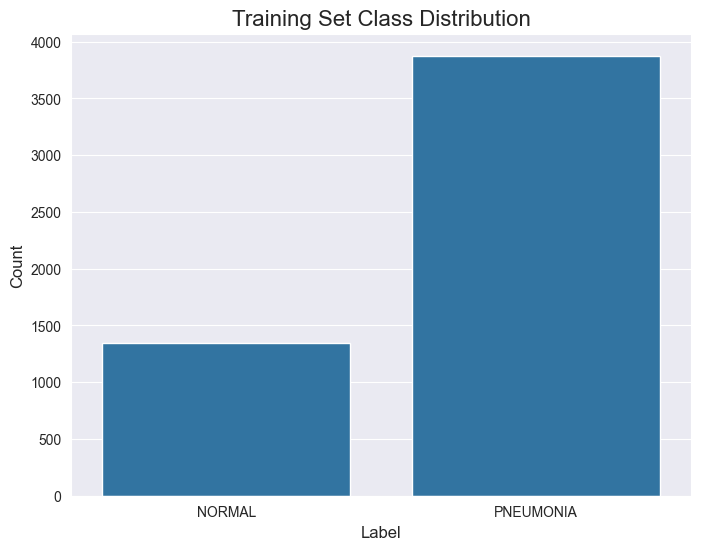

Imbalance ratio in Training set (PNEUMONIA:NORMAL): 2.89:1


In [13]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Label', y='Count', data=df_summary[df_summary['Split'] == 'train'])
plt.title('Training Set Class Distribution', fontsize=16)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

train_counts = pivot_summary.loc['train']
imbalance_ratio = train_counts['PNEUMONIA'] / train_counts['NORMAL']
print(f'Imbalance ratio in Training set (PNEUMONIA:NORMAL): {imbalance_ratio:.2f}:1')

As can be noticed above the training data is heavily skewed. In the training dataset, there are three times more pneumonia images than normal ones. This will be a very important challenge that we must address, otherwise we will end up with a model skewed towards pneumonia predictions, and poor performer on normal cases.

Here we have a couple of ways of handling this. One will be using class weighting, penalizing the model for misclassifying the minority, 'NORMAL' class. Another way of doing this is data augmentation on the minority class.

Let's now look at the all three sets barplots.

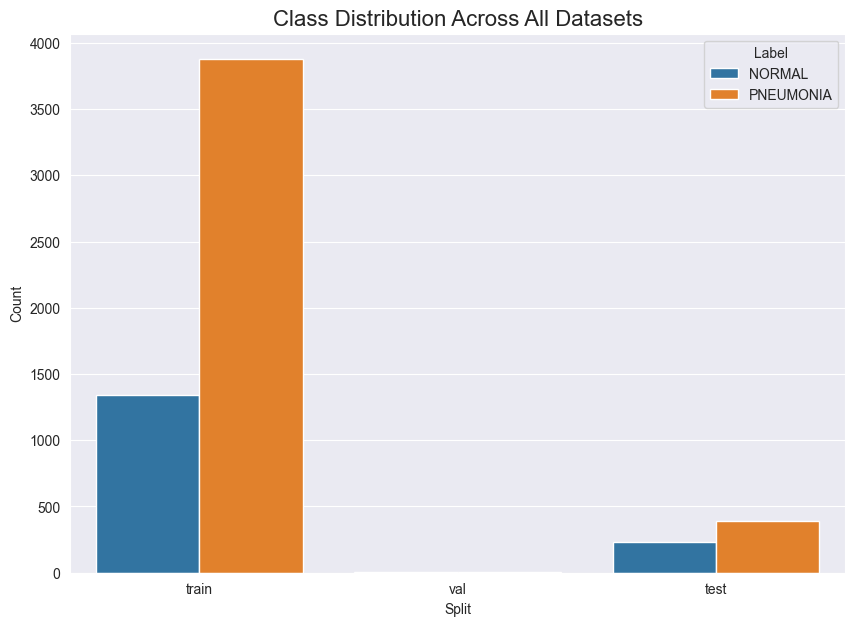

In [5]:
plt.figure(figsize=(10, 7))
sns.barplot(x='Split', y='Count', hue='Label', data=df_summary)
plt.title('Class Distribution Across All Datasets', fontsize=16)
plt.show()

The above distribution visualization reinforces what we said earlier, the val dataset is unusable. Also, the test set shows a slight imbalance.

Before we move on I think this is the perfect place to say that for creating a usable eval set, we will split the training data, I think a 90/10 split would be a good starting point. Having in mind the imbalance of classes, we need to make sure we use stratify to maintain the class imbalance in both the training and eval sets.

### 3. Display sample images

Here we should take a look at how an actual X-ray looks like. This helps to get a feel for the data and spot any potential issues.

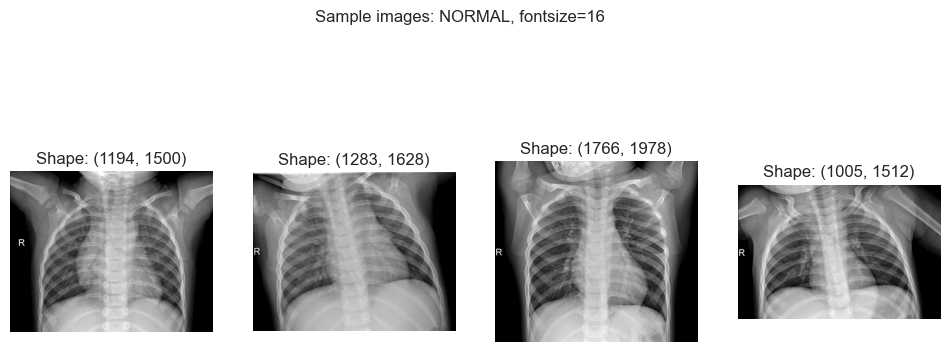

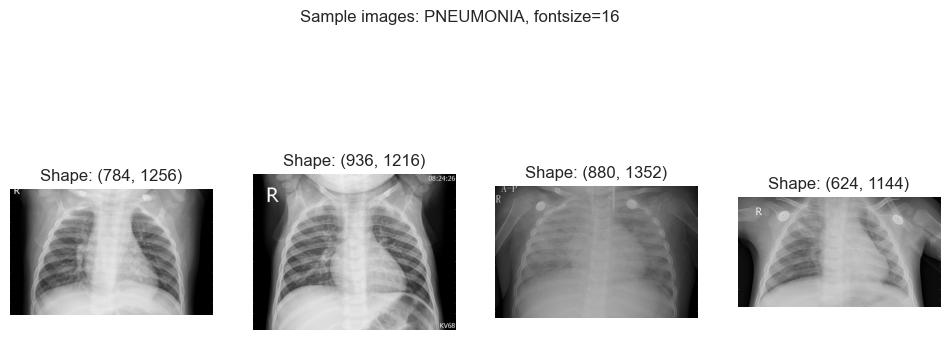

In [17]:
def show_sample_images(label, n_samples=4):
    path = os.path.join(train_path, label)
    image_files = np.random.choice(os.listdir(path), n_samples)

    plt.figure(figsize=(12, 5))
    plt.suptitle(f'Sample images: {label}, fontsize=16')

    for i, file in enumerate(image_files):
        img_path = os.path.join(path, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        plt.subplot(1, n_samples, i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(f'Shape: {img.shape}')

    plt.show()

show_sample_images('NORMAL')
show_sample_images('PNEUMONIA')

High inconsistency in the shape of the images in terms of shape and sizes. A preprocessing step to resize all images is mandatory for training a reliable model.

Let's look quantify this by using a distribution plot to show exactly how varied the sizes are.

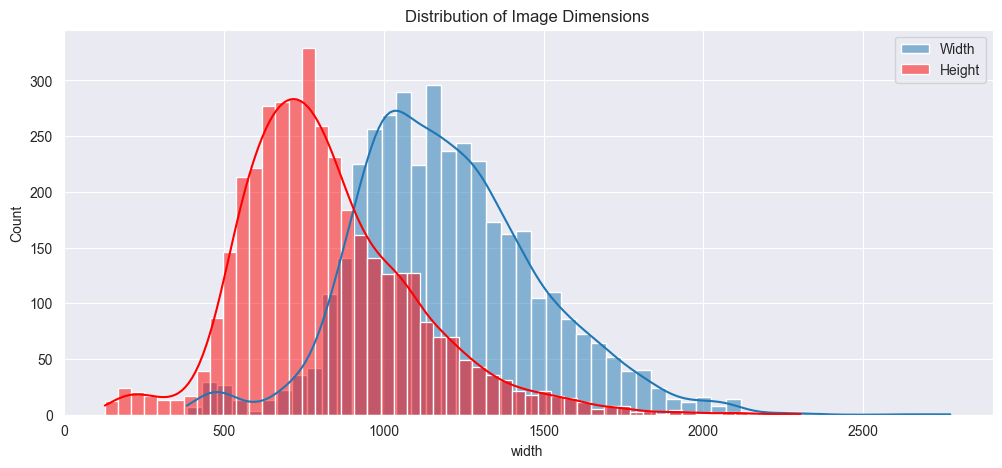

            height        width
count  3875.000000  3875.000000
mean    825.026839  1200.483613
std     277.073758   291.305676
min     127.000000   384.000000
25%     640.000000  1000.000000
50%     776.000000  1168.000000
75%     968.000000  1368.000000
max    2304.000000  2772.000000


In [21]:
all_train_images = glob(os.path.join(train_path, label, '**/*.jpeg'), recursive=True)
dims = []
for img_path in all_train_images:
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        dims.append(img.shape)

dims_df = pd.DataFrame(dims, columns=['height', 'width'])

plt.figure(figsize=(12, 5))
sns.histplot(dims_df['width'], kde=True, label='Width')
sns.histplot(dims_df['height'], kde=True, label='Height', color='red')
plt.title('Distribution of Image Dimensions')
plt.legend()
plt.show()

print(dims_df.describe())

What we can notice is that the height and width follow different, right-skewed distributions. Resizing all images to a uniform single-channel format like 256 x 256 x 1.

Before concluding this section, let's take a deeper look at differences between normal and pneumonia x-rays.

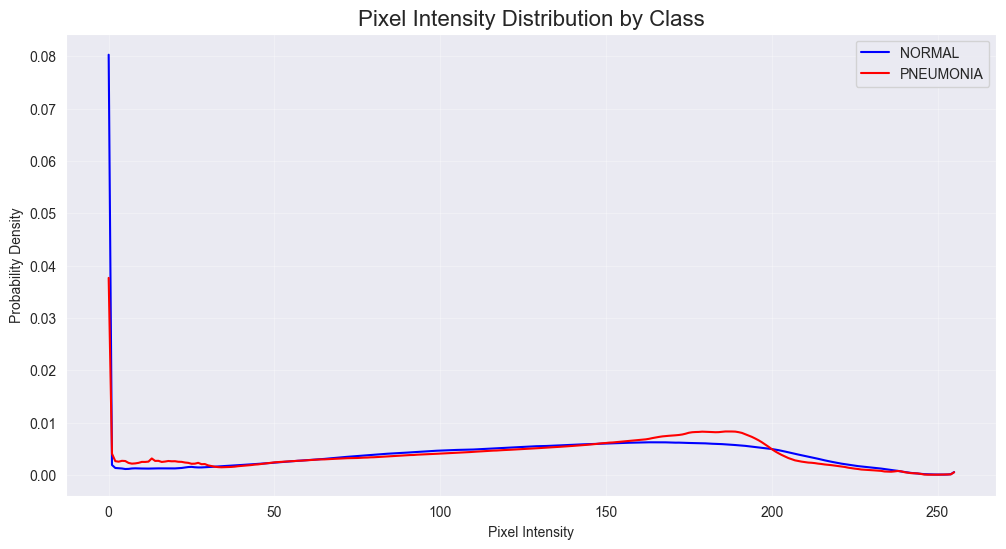

In [5]:
def plot_pixel_hist(label, color):
    paths = glob(os.path.join(train_path, label, '*.jpeg'))
    sample_paths = np.random.choice(paths, 100, replace=False)
    total_histogram = np.zeros(256)

    for img_path in sample_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            hist = cv2.calcHist([img], [0], None, [256], [0, 256])
            total_histogram += hist.flatten()

    total_histogram /= total_histogram.sum()

    plt.plot(total_histogram, color=color, label=label)

plt.figure(figsize=(12, 6))
plot_pixel_hist('NORMAL', color='blue')
plot_pixel_hist('PNEUMONIA', color='red')

plt.title('Pixel Intensity Distribution by Class', fontsize=16)
plt.xlabel('Pixel Intensity')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(alpha=0.3)
plt.show()




A line density plot was used, which allows us to see both distributions clearly on the same axes, making easier to spot any differences. Also by plotting the probability density instead of raw counts, we can make a one to one comparison of the shape of the distribution, regardless of the total number of pixels in each image, which the plot before this one can confirm that images come in different shape and sizes.

I would start with the elephant in the room, the huge spike at zero. First of all zero represents a black pixel. So the huge number of zero or near zero color pixels means that a large portion of the image is just pure black. It's a characteristic of the dataset, so with that out of our way we can move on to key insights.

For the pixel intensity around 150-200 we can see a spike in this brighter range. This might be a solid indication that pneumonia images have a significant higher concentration of pixels in the brighter pixels range.

Now with a quick google search, I can cross validate this finding, as radiologists will look for white spots in the lungs, called infiltrates that identify an infection.

This is good news as our future CNN model can learn that a higher prevalence of pixels in this brighter range is a strong indicator of pneumonia.

So an action plan will be to resize all images to a uniform dimension a 256 x 256 and normalize pixel values scaling between 0 and 1 in order to speed up and at the same time stabilize training.

#### 8. Conclusions

This will be an exciting dataset to work with, that has shown some caveats that we need to work on and keep in our minds when designing a performant CNN model. So let's try to reduce all that's has been said into a game plan:
* Enhance the eval set by splitting the training data in a 90/10 split, using stratify argument in order to ensure the original distribution of the data will remain in the split data sets
* Address the class imbalance by either class weighting or data augmentation (rotations, zoom, flips) on the minority class in order to address the imbalance
* Image preprocessing by resizing all images to a uniform dimension and normalizing the pixels